# import the libraries

In [1]:
import os
import shutil
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=50
class_names = {0:'Female', 1:'Male'}

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
age_data = pd.read_csv('train_age.csv')
gender_data = pd.read_csv('train_gender.csv')
merged_df = pd.merge(age_data, gender_data, on='imageId')
merged_df

,imageId,age,gender
0,0,89.0,0
1,1,72.0,0
2,2,25.0,1
3,3,68.0,1
4,4,37.0,0
...,...,...,...
10697,10697,79.0,0
10698,10698,67.0,0
10699,10699,66.0,1
10700,10700,78.0,0


# load data and create new folder

In [3]:
image_folder = 'data/train/'
merged_df['image_path'] = merged_df['imageId'].apply(lambda x: os.path.join(image_folder, f'{x:06d}.png'))

train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, shuffle=True)

train_folder = 'train/'
test_folder = 'test/'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

for index, row in train_df.iterrows():
    image_path = row['image_path']
    destination_path = os.path.join(train_folder, f"{row['imageId']:06d}.png")
    shutil.copyfile(image_path, destination_path)

for index, row in test_df.iterrows():
    image_path = row['image_path']
    destination_path = os.path.join(test_folder, f"{row['imageId']:06d}.png")
    shutil.copyfile(image_path, destination_path)

In [4]:
train_df = train_df.sort_values(by='imageId', ascending=True)
train_df = train_df.reset_index(drop=True)
train_df = train_df.drop('image_path', axis=1)
train_df

,imageId,age,gender
0,1,72.0,0
1,2,25.0,1
2,4,37.0,0
3,5,62.0,1
4,6,52.0,1
...,...,...,...
8556,10694,78.0,0
8557,10696,68.0,1
8558,10697,79.0,0
8559,10698,67.0,0


In [5]:
test_df = test_df.sort_values(by='imageId', ascending=True)
test_df = test_df.reset_index(drop=True)
test_df = test_df.drop('image_path', axis=1)
test_df

,imageId,age,gender
0,0,89.0,0
1,3,68.0,1
2,8,83.0,0
3,10,82.0,1
4,14,28.0,1
...,...,...,...
2136,10678,67.0,0
2137,10691,69.0,1
2138,10695,79.0,1
2139,10700,78.0,0


## Visualization

### Distribution of Genders in the Dataset

The code utilizes Seaborn, a powerful data visualization library, to create a countplot depicting the distribution of genders in the training dataset.

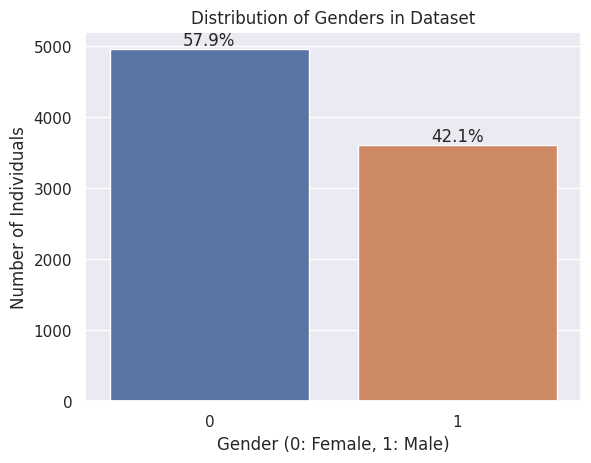

In [6]:
sns.set(style="darkgrid")
ax = sns.countplot(x="gender", data=train_df)

plt.xlabel("Gender (0: Female, 1: Male)")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Genders in Dataset")

total = len(train_df['gender'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show();

### Distribution of Age in the Dataset

The code employs Seaborn to create a histogram with a kernel density estimate (KDE) to illustrate the distribution of ages in the training dataset.

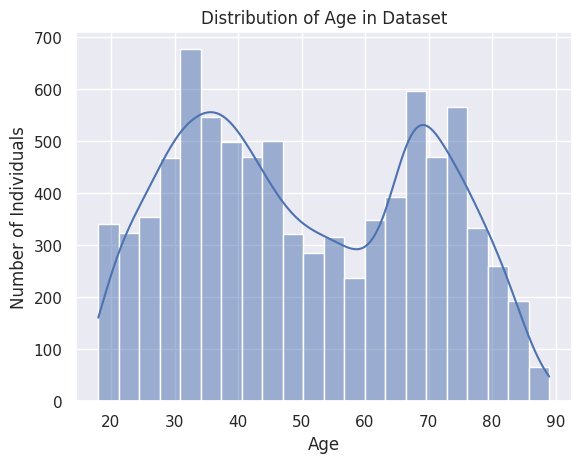

In [7]:
sns.histplot(data=train_df, x="age", kde=True)
plt.xlabel("Age")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Age in Dataset")
plt.show();

## Dataset Image Counts

Calculating the number of images in the training and test datasets:

In [8]:
train_data_dir = pathlib.Path(train_folder).with_suffix('')
test_data_dir = pathlib.Path(test_folder).with_suffix('')
train_image_count = len(list(train_data_dir.glob('*.png')))
test_image_count = len(list(test_data_dir.glob('*.png')))
print(f'There are {train_image_count} images in training dataset.')
print(f'There are {test_image_count} images in test dataset.')

There are 8561 images in training dataset.
There are 2141 images in test dataset.


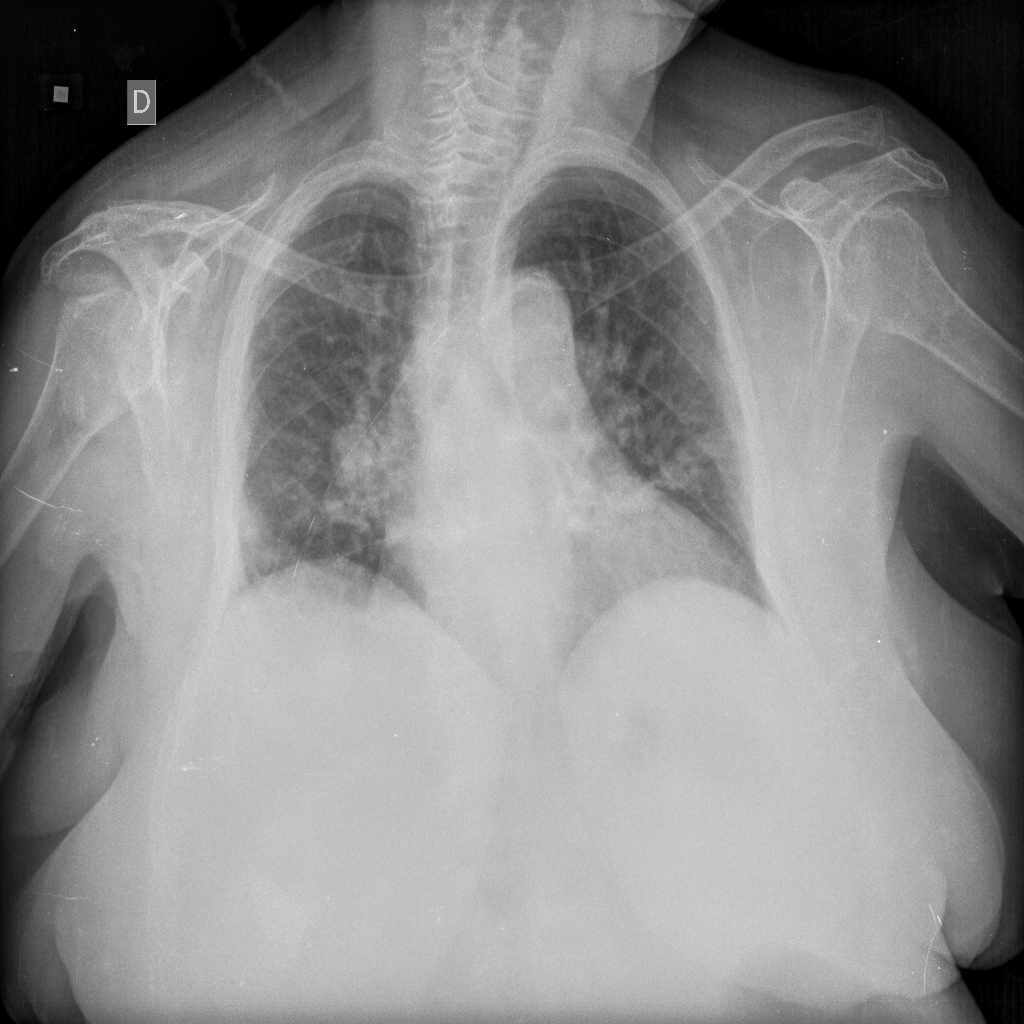

In [9]:
training = list(train_data_dir.glob('*'))
tf.keras.utils.load_img(str(training[0]))

# to check shape of the image 

In [10]:
def shape_of_xray_image(category, index):
    image_path = str(category[index])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    shape = tf.shape(image)
    print(f"Shape of the image: {shape}")

shape_of_xray_image(training, 0)

Shape of the image: [1024 1024    3]


## Age Dataset Creation

In [11]:
train_ds_age = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels=list(train_df['age']),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_ds_age = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels=list(train_df['age']),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 8561 files belonging to 72 classes.
Using 6849 files for training.
Found 8561 files belonging to 72 classes.
Using 1712 files for validation.


# data augmentation

In [12]:
train_ds_gender = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels=list(train_df['gender']),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_ds_gender = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels=list(train_df['gender']),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 8561 files belonging to 2 classes.
Using 6849 files for training.
Found 8561 files belonging to 2 classes.
Using 1712 files for validation.


## Class Weight Calculation for Gender Dataset

In [13]:
class_labels = np.array([label for images, labels in train_ds_gender for label in labels.numpy()])
class_counts = np.unique(class_labels, return_counts=True)[1]
class_weights = compute_class_weight("balanced", classes=np.unique(class_labels), y=class_labels)

for class_name, weight in zip(train_ds_gender.class_names, class_weights):
    print(f"Class '{class_name}': Weight {weight:.4f}")

Class '0': Weight 0.8635
Class '1': Weight 1.1878


In [14]:
class_weights = {0:class_weights[0], 1:class_weights[1]}
class_weights

{0: 0.863464447806354, 1: 1.1878251821019772}

These weights are useful for handling class imbalance during the training of a machine learning model for gender prediction.

# sample image

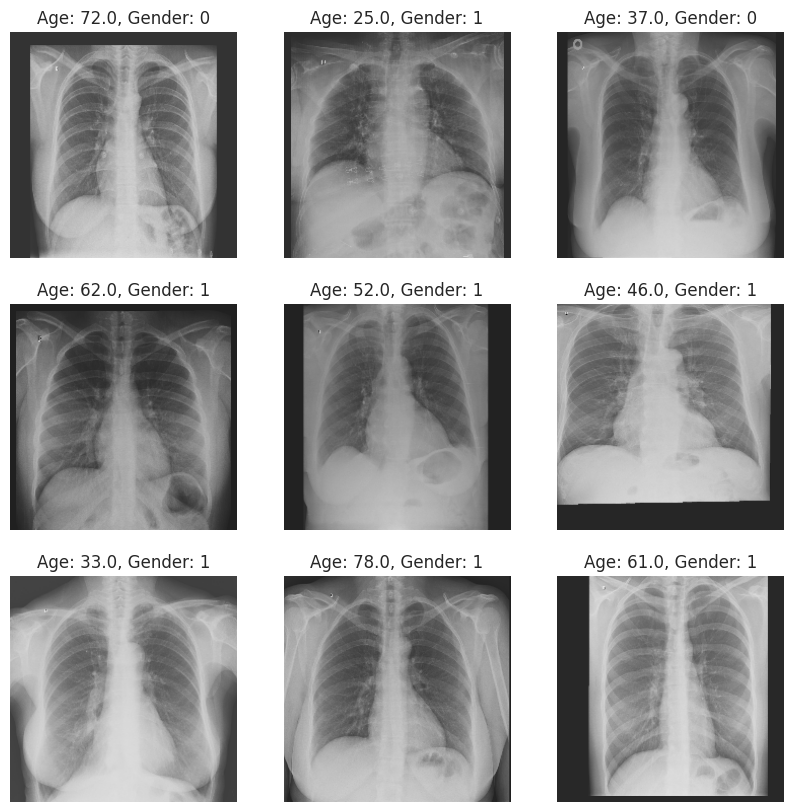

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_gender.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Age: {train_df['age'].iloc[i]}, Gender: {train_df['gender'].iloc[i]}")
    plt.axis("off")
plt.show()

## Batch Shape Inspection

In [16]:
for image_batch, labels_batch in train_ds_gender:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_age = train_ds_age.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds_gender = train_ds_gender.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_age = val_ds_age.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_gender = val_ds_gender.cache().prefetch(buffer_size=AUTOTUNE)

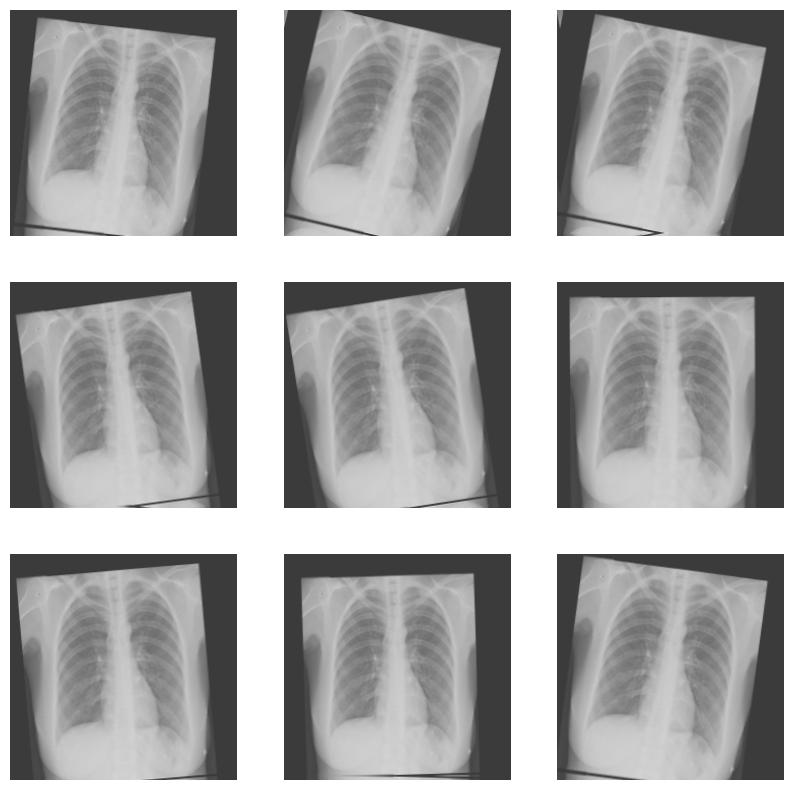

In [18]:
image_input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
layer = tf.keras.layers.RandomRotation(0.05)(image_input)
output = tf.keras.layers.RandomZoom(0.05)(layer)
image_input_and_augmentation = tf.keras.Model(inputs = [image_input], outputs = [output])

plt.figure(figsize=(10, 10))
for images, _ in train_ds_age.take(1):
  for i in range(9):
    augmented_images = image_input_and_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# convolutional layer

In [19]:
def convolutional_block(filter, layer):
    layer = tf.keras.layers.Conv2D(filter, (3,3), activation='relu')(layer)
    layer = tf.keras.layers.MaxPooling2D(2,2)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Dropout(0.20)(layer)
    return layer

def dense_block(nodes, layer):
    layer = tf.keras.layers.Dense(nodes, activation='relu')(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Dropout(0.25)(layer)
    return layer

## Age Prediction Model Architecture

This code defines the architecture of an age prediction model using TensorFlow's Keras API. The model includes layers for data normalization, random rotation and zoom augmentation, convolutional blocks, global average pooling, dense blocks, and a final output layer. The model is compiled with a mean squared error loss function, and additional metrics for evaluation. Early stopping and learning rate scheduling callbacks are incorporated for model training. The `summary()` function provides a summary of the model's architecture.

# model artitecture 

In [20]:
image_input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
normalized_image = tf.keras.layers.BatchNormalization()(image_input)
layer = tf.keras.layers.RandomRotation(0.05)(normalized_image)
augmented_image = tf.keras.layers.RandomZoom(0.05)(layer)
c1 = convolutional_block(32, augmented_image)
c2 = convolutional_block(64, c1)
c3 = convolutional_block(128, c2)
c4 = convolutional_block(128, c3)
c5 = convolutional_block(128, c4)
gap2d = tf.keras.layers.GlobalAveragePooling2D()(c5)
flattened = tf.keras.layers.Flatten()(gap2d)
d1 = dense_block(128, flattened)
d2 = dense_block(64, d1)
d3 = dense_block(32, d2)
output = tf.keras.layers.Dense(1, activation='relu')(d3)

age_model = tf.keras.Model(inputs=[image_input], outputs=[output])

age_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=tf.metrics.MeanSquaredError())
              
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
lr_sch = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 5, factor = 0.1, verbose = 1, min_lr = 5e-10)

age_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0   

## Gender Prediction Model Architecture

This code defines the architecture of a gender prediction model using TensorFlow's Keras API. The model includes layers for data normalization, random rotation and zoom augmentation, convolutional blocks, global average pooling, dense blocks, and a final output layer with sigmoid activation for binary classification. The model is compiled with binary crossentropy loss and additional metrics for evaluation. The `summary()` function provides a summary() of the model's architecture.

In [21]:
image_input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
normalized_image = tf.keras.layers.BatchNormalization()(image_input)
layer = tf.keras.layers.RandomRotation(0.05)(normalized_image)
augmented_image = tf.keras.layers.RandomZoom(0.05)(layer)
c1 = convolutional_block(32, augmented_image)
c2 = convolutional_block(64, c1)
c3 = convolutional_block(128, c2)
c4 = convolutional_block(128, c3)
c5 = convolutional_block(128, c4)
gap2d = tf.keras.layers.GlobalAveragePooling2D()(c5)
flattened = tf.keras.layers.Flatten()(gap2d)
d1 = dense_block(128, flattened)
d2 = dense_block(64, d1)
d3 = dense_block(32, d2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(d3)

gender_model = tf.keras.Model(inputs=[image_input], outputs=[output])

gender_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

gender_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization_9 (Bat  (None, 224, 224, 3)       12        
 chNormalization)                                                
                                                                 
 random_rotation_2 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_2 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0   

## Age Prediction Model Training

This code block trains the age prediction model using the training dataset (`train_ds_age`). The training process includes validation on the validation dataset (`val_ds_age`) and is run for a specified number of epochs (`EPOCHS`). Callbacks, such as early stopping and learning rate scheduler, are used to monitor and improve the training process.

In [22]:
age_history = age_model.fit(train_ds_age,
                            validation_data=val_ds_age,
                            epochs=EPOCHS,
                            callbacks=[early_stopping, lr_sch])

Epoch 1/50


2024-08-31 09:41:38.802552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


215/215 [==============================] - 47s 170ms/step - loss: 2426.1809 - mean_squared_error: 2426.1809 - val_loss: 1525.7084 - val_mean_squared_error: 1525.7084 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 23s 109ms/step - loss: 1737.2278 - mean_squared_error: 1737.2278 - val_loss: 981.7503 - val_mean_squared_error: 981.7503 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 24s 109ms/step - loss: 1146.2976 - mean_squared_error: 1146.2976 - val_loss: 776.8779 - val_mean_squared_error: 776.8779 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 24s 110ms/step - loss: 781.0714 - mean_squared_error: 781.0714 - val_loss: 513.3597 - val_mean_squared_error: 513.3597 - lr: 0.0010
Epoch 5/50
215/215 [==============================] - 23s 109ms/step - loss: 619.6329 - mean_squared_error: 619.6329 - val_loss: 486.5110 - val_mean_squared_error: 486.5110 - lr: 0.0010
Epoch 6/50
215/215 [==============================] - 23s 109ms/step - lo

## Age Prediction Model Training Visualization

This code block generates a visual representation of the training history for the age prediction model. The left subplot shows the training and validation loss over epochs, while the right subplot displays the mean squared error and its validation counterpart. The visualization helps in assessing the model's performance during training.

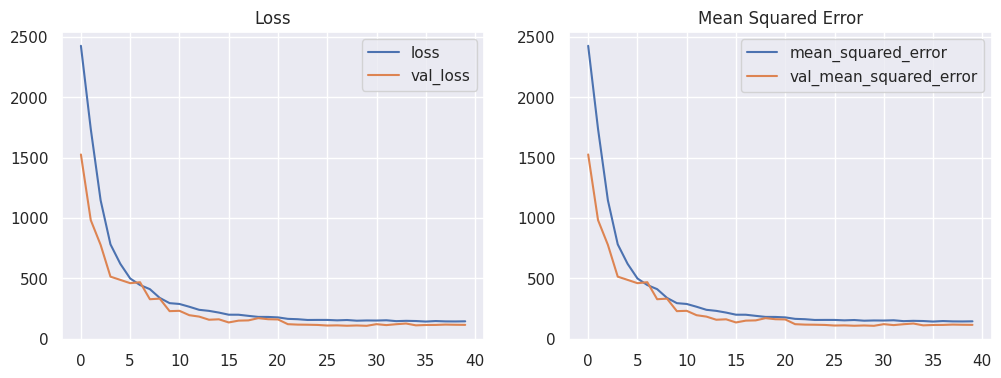

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
pd.DataFrame(age_history.history).loc[:,['loss', 'val_loss']].plot(ax=axs[0], title="Loss")
pd.DataFrame(age_history.history).loc[:,['mean_squared_error','val_mean_squared_error']].plot(ax=axs[1], title="Mean Squared Error");

## Gender Model Training


In [24]:
gender_history = gender_model.fit(train_ds_gender,
                                  validation_data=val_ds_gender,
                                  epochs=EPOCHS,
                                  class_weight=class_weights,
                                  callbacks=[early_stopping, lr_sch])

Epoch 1/50


2024-08-31 09:58:02.915089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


215/215 [==============================] - 96s 171ms/step - loss: 0.6845 - binary_accuracy: 0.6189 - precision: 0.5399 - recall: 0.6410 - val_loss: 1.2196 - val_binary_accuracy: 0.4229 - val_precision: 0.4229 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 24s 110ms/step - loss: 0.5512 - binary_accuracy: 0.7203 - precision: 0.6478 - recall: 0.7350 - val_loss: 1.5639 - val_binary_accuracy: 0.4229 - val_precision: 0.4229 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 24s 110ms/step - loss: 0.4878 - binary_accuracy: 0.7674 - precision: 0.7007 - recall: 0.7811 - val_loss: 1.3515 - val_binary_accuracy: 0.4369 - val_precision: 0.4287 - val_recall: 0.9972 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 24s 110ms/step - loss: 0.4179 - binary_accuracy: 0.8128 - precision: 0.7493 - recall: 0.8345 - val_loss: 1.3153 - val_binary_accuracy: 0.4614 - val_precision: 0.4399 - val_recall: 1.0000 - lr: 0.

## Gender Prediction Model Training Visualization

This code block generates a visual representation of the training history for the gender prediction model. The left subplot shows the training and validation loss over epochs, while the right subplot displays binary accuracy and its validation counterpart. The visualization helps in assessing the model's performance during training.

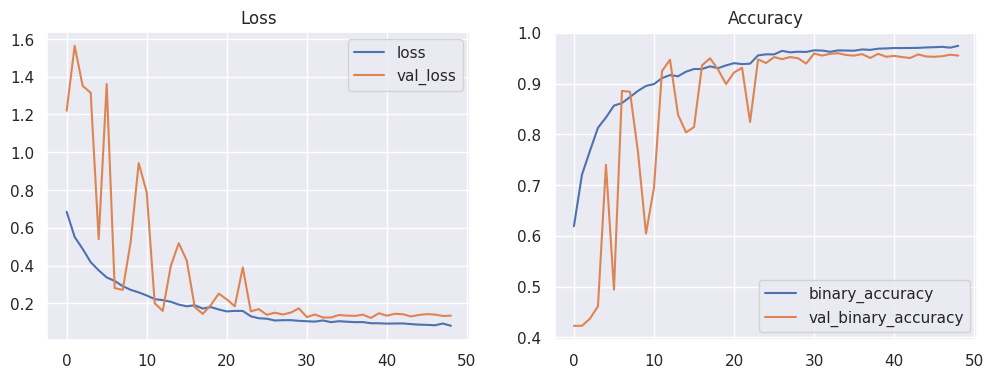

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
pd.DataFrame(gender_history.history).loc[:, ['loss', 'val_loss']].plot(ax=axs[0], title="Loss")
pd.DataFrame(gender_history.history).loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(ax=axs[1], title="Accuracy");

## Test data generator for Age and Gender Models

In [26]:
test_ds_age = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  labels=list(test_df['age']),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

test_ds_gender = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  labels=list(test_df['gender']),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 2141 files belonging to 72 classes.
Found 2141 files belonging to 2 classes.


## Evaluation of Age Prediction Model on Test Dataset

In [27]:
age_model.evaluate(test_ds_age)

67/67 [==============================] - 17s 226ms/step - loss: 101.7598 - mean_squared_error: 101.7598


[101.75982666015625, 101.75982666015625]

## Evaluation of Gender Prediction Model on Test Dataset

In [28]:
gender_model.evaluate(test_ds_gender)

67/67 [==============================] - 16s 207ms/step - loss: 0.1267 - binary_accuracy: 0.9603 - precision: 0.9311 - recall: 0.9763


[0.12671776115894318,
 0.9602989554405212,
 0.9311087131500244,
 0.9762979745864868]

## Prediction of Age and Gender 

In [29]:
def predict_image(example):
    img = tf.keras.utils.load_img(example, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    age_prediction = age_model.predict(img_array)
    age_prediction = int(age_prediction)
    gender_prediction = gender_model.predict(img_array)
    gender_prediction = 0 if gender_prediction < 0.50 else 1
    predicted_gender = class_names[gender_prediction]

    print(f"This image most likely belongs to {age_prediction} old {predicted_gender}")
    
predict_image('test/000000.png')

1/1 [==============================] - 0s 209ms/step
This image most likely belongs to 65 old Female


## Save Trained Models

In [30]:
gender_model.save('gender_model.h5')
age_model.save('age_model.h5')

# user prediction

In [1]:
import tensorflow as tf
# class_names = {0:'Female', 1:'Male'}
# Load models
gender_model = tf.keras.models.load_model('gender_model.h5')
age_model = tf.keras.models.load_model('age_model.h5')

# Class names for gender prediction
class_names = ['Male', 'Female']  # Update this based on your class labels

# Function to predict age and gender from an image
def predict_image(example):
    img = tf.keras.utils.load_img(example, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    age_prediction = age_model.predict(img_array)
    age_prediction = int(age_prediction[0][0])  # Assuming a single output node for age prediction

    gender_prediction = gender_model.predict(img_array)
    gender_prediction = 0 if gender_prediction[0][0] < 0.50 else 1  # Assuming a single output node for gender prediction

    predicted_gender = class_names[gender_prediction]

    print(f"This image most likely belongs to a {age_prediction} year old {predicted_gender}")

# Example usage
predict_image(r'000033.png')


1/1 [==============================] - 0s 168ms/step
This image most likely belongs to a 51 year old Female


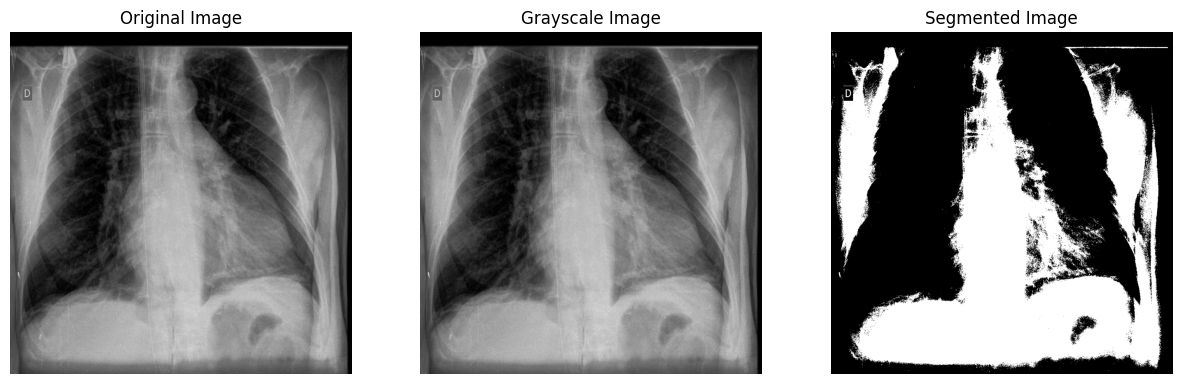

In [1]:
import cv2
import matplotlib.pyplot as plt

# Read the image
image_path = r'test\000157.png'

image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to segment the image
_, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Display the original, grayscale, and segmented images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Grayscale Image
plt.subplot(1, 3, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# Segmented Image
plt.subplot(1, 3, 3)
plt.imshow(binary_image, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()
